# ULMFiT + Siamese Network for Sentence Vectors
## Part Two: Pretraining
This notebook will build a language model from lesson 10 of the Fast ai course and retrain it on the SNLI dataset. 


In [6]:
%matplotlib inline
from fastai.text import *
import json
import html
import re
import pickle
import random
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn import model_selection
from functools import partial
from collections import Counter, defaultdict
import torch
import torch.nn as nn
import torch.utils 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import dataset, dataloader
import torch.optim as optim
import torch.nn.functional as F
import time
import math
import sys
import data
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize #package for flattening json in pandas df
from IPython.display import display
from sklearn import metrics
import os
import logging
from ipyexperiments import IPyExperimentsPytorch
from ipygpulogger import IPyGPULogger
import pickle
from collections import Counter
import random
import joblib

train = './data/train.pkl'
val = './data/val.pkl'

In [7]:
train_df = joblib.load(train)
val_df = joblib.load(val)

In [8]:
exp0 = IPyExperimentsPytorch()
data_lm=TextLMDataBunch.from_df('.', train_df=train_df, valid_df=val_df, text_cols=['known', 'unknown'], label_cols=['label'])
data_cl=TextClasDataBunch.from_df('.', train_df=train_df, valid_df=val_df, text_cols=['known', 'unknown'], label_cols=['label'], vocab=data_lm.train_ds.vocab)
data_lm.save()
data_cl.save()
del exp0


*** Experiment finished in 00:00:17 (elapsed wallclock time)

*** Local variables:
Deleted: data_cl, data_lm

*** Experiment memory:
RAM:  Consumed     Reclaimed
CPU: 240.6 MB  76.1 MB ( 31.62%)
GPU: -64.0 KB    0.0 B ( -0.00%)

*** Current state:
RAM:   Used      Free     Total    Util
CPU:   2.4 GB   54.1 GB  62.8 GB   4.50% 
GPU:   1.1 GB    6.8 GB   7.9 GB  15.93% 




In [23]:
exp1 = IPyExperimentsPytorch()
data_lm = TextLMDataBunch.load('.')
em_sz,nh,nl = 400,1150,3
max_seq = 20*70
wd = 1e-7
bptt = 70
batch_size = 32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1,  metrics=[accuracy],
                              drop_mult=0.8, wd=1e-8, bptt=70)
learn.freeze_to(-1)



*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1070 (7.9 GB RAM)

*** Current state:
RAM:   Used      Free     Total    Util
CPU:   2.9 GB   53.6 GB  62.8 GB   5.48% 
GPU:   2.5 GB    5.4 GB   7.9 GB  46.09% 



*** Experiment finished in 00:29:26 (elapsed wallclock time)

*** Local variables:
Deleted: exp1, lr, lrs
NameError: name 'lr' is not defined

*** Experiment memory:
RAM:  Consumed     Reclaimed
CPU:  59.4 MB    0.0 B (  0.00%)
GPU:   1.3 GB    0.0 B (  0.00%)

*** Current state:
RAM:   Used      Free     Total    Util
CPU:   2.9 GB   53.6 GB  62.8 GB   5.48% 
GPU:   2.5 GB    5.4 GB   7.9 GB  46.09% 



*** Experiment finished in 00:00:00 (elapsed wallclock time)

*** Local variables:
Deleted: 

*** Circular ref objects gc collected during the experiment:
cleared 22 objects (only temporary leakage)

*** Experiment memory:
RAM:  Consumed     Reclaimed
CPU:    0.0 B    0.0 B (100.00%)
GPU:    0.0 B    0.0 B (100.00%)

*** Current state:
RAM:   Used   

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


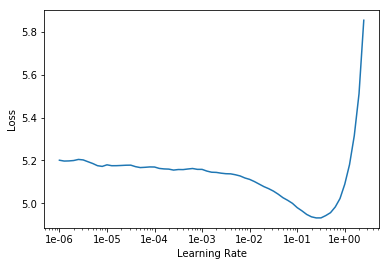

In [24]:
learn.lr_find(num_it=80)
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(1, 1e-02, wd=1e-8)
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy
1,3.593850,3.553949,0.335129


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


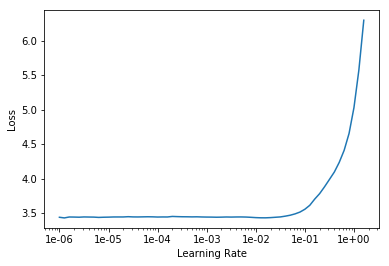

In [27]:
learn.lr_find(num_it=80)
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(1, slice(1e-6/2,1e-5))

epoch,train_loss,valid_loss,accuracy
1,3.415814,3.549459,0.335455


In [29]:
learn.save_encoder('ft_enc')
learn.save()
del exp1

NameError: name 'exp1' is not defined

## Load the tokens from the SNLI data

In [4]:
itos = pickle.load(open(f'{token_files}itos.pkl', 'rb'))
trn_lm = np.load(f'{token_files}trn_lm.npy')
val_lm = np.load(f'{token_files}val_lm.npy')

stoi = defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
vocab_size = len(itos)
vocab_size

34160

In [5]:
# check to make sure that the data looks ok
for word in trn_lm[:100]:
    print(itos[word], end=" ")

x_bos a very young child in a denim baseball cap eats a green apple . x_bos a boy combing a young baby 's hair . x_bos the boy was jumping on a platform . x_bos a little girl jumps while playing on the beach . x_bos two people are on the ocean . x_bos a girl is laughing because something terrible happened to someone she hates . x_bos the old woman is about to tell a story . x_bos the female is practicing while wearing no shoes . x_bos the boy is playing on the soccerfield . x_bos an african 

## Load the Wikitext LM and fix the weights

In [12]:
def convert(path_to_old_model, path_to_save_converted_model):
    """
    path_to_old_model is the path to old model 
    and 
    path_to_save_converted_model is the path where the converted model is stored
    """
    old_wgts = torch.load(path_to_old_model, map_location=lambda storage, loc: storage)
    new_wgts = OrderedDict()
    new_wgts['encoder.weight']=old_wgts['0.encoder.weight']
    new_wgts['encoder_dp.emb.weight']=old_wgts['0.encoder_with_dropout.embed.weight']
    new_wgts['rnns.0.weight_hh_l0_raw']=old_wgts['0.rnns.0.module.weight_hh_l0_raw']
    new_wgts['rnns.0.module.weight_ih_l0']=old_wgts['0.rnns.0.module.weight_ih_l0']
    new_wgts['rnns.0.module.weight_hh_l0']=old_wgts['0.rnns.0.module.weight_hh_l0_raw']
    new_wgts['rnns.0.module.bias_ih_l0']=old_wgts['0.rnns.0.module.bias_ih_l0']
    new_wgts['rnns.0.module.bias_hh_l0']=old_wgts['0.rnns.0.module.bias_hh_l0']
    new_wgts['rnns.1.weight_hh_l0_raw']=old_wgts['0.rnns.1.module.weight_hh_l0_raw']
    new_wgts['rnns.1.module.weight_ih_l0']=old_wgts['0.rnns.1.module.weight_ih_l0']
    new_wgts['rnns.1.module.weight_hh_l0']=old_wgts['0.rnns.1.module.weight_hh_l0_raw']
    new_wgts['rnns.1.module.bias_ih_l0']=old_wgts['0.rnns.1.module.bias_ih_l0']
    new_wgts['rnns.1.module.bias_hh_l0']=old_wgts['0.rnns.1.module.bias_hh_l0']
    new_wgts['rnns.2.weight_hh_l0_raw']=old_wgts['0.rnns.2.module.weight_hh_l0_raw']
    new_wgts['rnns.2.module.weight_ih_l0']=old_wgts['0.rnns.2.module.weight_ih_l0']
    new_wgts['rnns.2.module.weight_hh_l0']=old_wgts['0.rnns.2.module.weight_hh_l0_raw']
    new_wgts['rnns.2.module.bias_ih_l0']=old_wgts['0.rnns.2.module.bias_ih_l0']
    new_wgts['rnns.2.module.bias_hh_l0']=old_wgts['0.rnns.2.module.bias_hh_l0']

    torch.save(new_wgts, path_to_save_converted_model+'converted_model.pth')

In [6]:
#these are the values used for the original LM
em_sz,nh,nl = 400,1150,3
PATH = Path('./data/aclImdb')
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [7]:
#get the mean weight value for any new vocab
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

itos2 = pickle.load(Path(PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

#fill in the missing values from the old vocab
new_w = np.zeros((vocab_size, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m
    
#fix up the wgts with the new values
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [8]:
max_seq = 20*70
wd = 1e-7
bptt = 70
batch_size = 32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(trn_lm, batch_size, bptt)
val_dl = LanguageModelLoader(val_lm, batch_size, bptt)
md = LanguageModelData(PATH, 1, vocab_size, trn_dl, val_dl, bs=batch_size, bptt=bptt)

### Create the language model and load the weigths

In [9]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
learner = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

learner.model.load_state_dict(wgts)

In [10]:
lr=1e-3
lrs = lr
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      3.417712   3.237231   0.394114  



[3.237231071355642, 0.3941137604774769]

In [11]:
learner.unfreeze()

In [12]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy   
    0      3.126726   3.002443   0.417283  



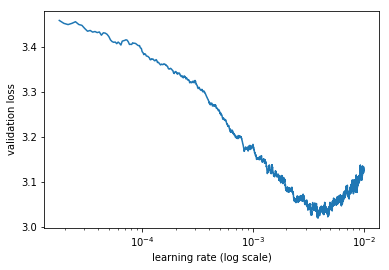

In [13]:
learner.sched.plot()

In [14]:
lrs=0.004
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy   
    0      2.888024   2.757168   0.446942  
    1      2.853163   2.717702   0.452594  
    2      2.780269   2.647655   0.464938  
    3      2.716107   2.590034   0.475679  
    4      2.672535   2.540915   0.485196  
    5      2.637532   2.499195   0.493423  
    6      2.600963   2.458995   0.500602  
    7      2.53759    2.423469   0.507219  
    8      2.495851   2.390064   0.513193  
    9      2.474802   2.3605     0.518039  
    10     2.432823   2.330059   0.523042  
    11     2.3932     2.303556   0.527746  
    12     2.350647   2.276374   0.532724  
    13     2.328032   2.254468   0.536535  
    14     2.320836   2.238188   0.539734  



[2.2381879509070295, 0.5397343000702536]

In [15]:
torch.save(learner.model, "snli_language_model.pt")